# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

## Preparing Data

본 과제에서는 pytorch version 1.8.0, torchtext version 0.9, spacy version 3.0을 사용하였으며, pytorch 버전에 맞는 cuda를 함께 install해 device로 GPU를 사용하여 진행하였다.
conda 가상환경을 사용하여 로컬에서 학습하였다.

주의 : torchtext는 현재 0.13.0 버전까지 나와있지만, legacy를 지원하지 않기 때문에 이전버전을 사용하여야 한다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

여기서 <br>
!python -m spacy download en_core_web_sm <br>
!python -m spacy download de_core_news_sm <br>
코드를 사용해 모델을 다운로드 할 수 있다. <br>
본 과제에서는 필요한 데이터셋을 전부 가상환경에 설치해놨기에 따로 install을 할 필요가 없이, 그대로 불러오는것이 가능하다.

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

tokenizer정의


In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

여기서는 데이터의 전처리를 진행한다.<br>
SRC는 tokenize_de(독일어 tokenizer)를 사용해 데이터를 토큰화하고, 문장의 시작을 알리는 init_token을 "sos", 끝을 알리는 eos_token을 "eos"로 정의하며, lower = ture는 모든 문자는 소문자처리를 한다는 의미이다.<br>
위와 동일하게 TRG에 대한 전처리도 진행한다.

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

데이터를 다운로드하고 로드한다.<br>
Multi30k 데이터셋을 사용하며, 사용할 언어인 독일어(.de) 와 영어(.en)을 지정해준다.<br>
로드되는 데이터를 각각 train_data, valid_data, test_data로 정의해준다.


In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

vocab을 만드는 과정이다.<br>
본 과제에서는 최소 출현 횟수가 2번인 단어들을 가지고 vocab을 만들었다.

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [39]:
print(len(SRC.vocab))
SRC.vocab.stoi

7853


defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000001DC543542E0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '.': 4,
             'ein': 5,
             'einem': 6,
             'in': 7,
             'eine': 8,
             ',': 9,
             'und': 10,
             'mit': 11,
             'auf': 12,
             'mann': 13,
             'einer': 14,
             'der': 15,
             'frau': 16,
             'die': 17,
             'zwei': 18,
             'einen': 19,
             'im': 20,
             'an': 21,
             'von': 22,
             'sich': 23,
             'dem': 24,
             'mädchen': 25,
             'junge': 26,
             'vor': 27,
             'zu': 28,
             'steht': 29,
             'männer': 30,
             'sitzt': 31,
             'hund': 32,
             'den': 33,
             'straße': 34,
             'während': 35,
     

여기서는 학습에 사용할 device를 정의할 수 있다.<br>
본 과제에서는 device로 cuda를 사용하여 진행하였다.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Create the iterators.

In [9]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model

### Encoder

본 과제에서는 encoder로 single layer GRU를 사용하지만 bidirection GRU를 사용한다. A *forward RNN*의 경우 문장의 왼쪽부터 오른쪽으로(정방향) embedding한다(shown below in green), and a *backward RNN*의 경우 문장의 오른쪽부터 왼쪽으로(역방향) embedding한다(teal).<br>
코드에서 구현하는 방법은 다음과 같다 : set `bidirectional = True` 

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

위와 같이 encoder를 구현하게 되면:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

통상적으로는 initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively)를 0으로 정의하는 경우가 많다. bidirection이기에 encoder에서 2개의 context vector를 얻을 수 있다. 하나는 정방향에 대한 context vector $z^\rightarrow=h_T^\rightarrow$, 그리고 또 하나는 역방향에 대한 context vector $z^\leftarrow=h_T^\leftarrow$ 이다.

그리고 `outputs`과 `hidden`을 반환한다. 

`outputs`은 **[src len, batch size, hid dim * num directions]** 의 size를 가지고 있고, 정, 역 방향의 hidden states를 concatenate를 한다. i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$. 그러므로 모든 encoder의 hidden states들은 $H=\{ h_1, h_2, ..., h_T\}$ 이런식으로 표현이 가능하다..

`hidden`는 **[n layers * num directions, batch size, hid dim]**의 size를 가지고 있으며, **[-2, :, :]** 이런식으로 정방향의 hidden state를 표현할 수 있으며, 마찬가지로 **[-1, :, :]** 이런식으로 역방향의 hidden state를 표현할 수 있다.

decoder는 dibirectional이 아니기에 2개의 context vector를 하나로 합쳐야 한다.

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$


In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True) # --> bidirectional = True
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

torch.cat의 사용법을 확인하기 위해 임의의 코드를 실행해 보았다.

In [40]:
N, X, Y = 2, 4, 4

x = torch.rand(N, X, Y)
#y = torch.rand(N, X, Y)

print(x.shape)
print(x)
c = torch.cat((x[-1,:,:], x[-2,:,:]), dim = 1)
print(c)
print(c.shape)
z = nn.Linear(8,2)
print(torch.tanh(z(c)).shape)

torch.Size([2, 4, 4])
tensor([[[0.1458, 0.5750, 0.0962, 0.2682],
         [0.7423, 0.7623, 0.8793, 0.2164],
         [0.7069, 0.6294, 0.1964, 0.5383],
         [0.5818, 0.7092, 0.6070, 0.1860]],

        [[0.8810, 0.2176, 0.0394, 0.4025],
         [0.5740, 0.0355, 0.3610, 0.6851],
         [0.4076, 0.0712, 0.1245, 0.8271],
         [0.3821, 0.9719, 0.7674, 0.0683]]])
tensor([[0.8810, 0.2176, 0.0394, 0.4025, 0.1458, 0.5750, 0.0962, 0.2682],
        [0.5740, 0.0355, 0.3610, 0.6851, 0.7423, 0.7623, 0.8793, 0.2164],
        [0.4076, 0.0712, 0.1245, 0.8271, 0.7069, 0.6294, 0.1964, 0.5383],
        [0.3821, 0.9719, 0.7674, 0.0683, 0.5818, 0.7092, 0.6070, 0.1860]])
torch.Size([4, 8])
torch.Size([4, 2])


nn.Embedding의 사용법 혹은 효과가 무엇인지 알아보기 위해 임의의 코드를 실행해 보았다.

In [41]:
embedding = nn.Embedding(10, 3)

a = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
print(a.shape)

a_1 = embedding(a)
print(a_1.shape)

torch.Size([2, 4])
torch.Size([2, 4, 3])


### Attention

Attention에서 encoder의 hidden state인 H는 T개의 텐서가 합쳐져있는 형태이다. 하지만 decoder에서의 hidden state는 하나의 텐서이기에, 차원수를 맞추어 주기 위해 unsqueeze()함수를 사용하여 src len 차원을 하나 추가하고 이를 T번만큼 repeat 해준다.

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

이를 통해 encoder의 hidden state가 decoder hidden state와 얼마나 잘 “match”되는지 알 수 있다.

위의 식에서 구한 energy Et는 [dec hid dim, src len]의 size를 가지고있다.<br>
이를 [src len]으로 변환하기 위해 아래의 수식을 사용한다. <br>
energy에 **[1, dec hid dim]** 텐서인, $v$를 곱해준다.

$$\hat{a}_t = v E_t$$

v = [1, dec hid dim]의 size를 가지고있으며, Et의 가중치로 볼 수 있다. 마지막에는 squeeze()함수를 사용해 차원 하나를 삭제함으로써 [src len]의 size를 얻는다.

attention vector는 위의 식에 softmax를 사용하여 0~1까지의 값을 취하고, 합이 1이 된다.

$$a_t = \text{softmax}(\hat{a_t})$$

최종적으로 source sentence 길이 만큼의, 각각의 src token에 얼마만큼 attention 해야하는지 가중치가 담긴 attention vector가 산출된다.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1) 
        # --> 1번째 위치에 차원을 하나 추가한다. 그리고 encoder의 T -- src len만큼 reqeat를 진행해 차원을 맞추어준다.
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # --> permute 함수는 원래 있던 차원의 원소의 순서를 바꾸어주는 함수이다. 이를 통해 hidden과 encoder_outputs의 concate를 진행한다.
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        #attn 함수는 (enc_hid_dim * 2) + dec_hid_dim를 인풋으로 받고 dec_hid_dim을 아웃풋으로 낸다.

        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        # squeeze함수를 사용해 2번 차원을 제거한다.
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder


이 전 time step의 hidden state, $s_{t-1}$,와 source sentence의 hidden states, $H$, 이 둘을 사용하여 해당 time step의 attention vector, $a_t$를 구합니다.

밑의 식에서 확인할 수 있듯이, $w_t$, weighted source vector는, source sentence의 hidden states, $H$, attention vector $a_t$를 통해 계산할 수 있으며, 여기서 attention vector $a_t$는 가중치로 여길 수 있다.

$$w_t = a_t H$$

embedded input word, $d(y_t)$, 그리고 the weighted source vector, $w_t$, 마지막으로 이전 time step의 decoder hidden state, $s_{t-1}$, 를 decoder RNN으로 넣는다. 밑의 식을 통해 현재 time step의 decoder hidden state를 계산할 수 있다.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

위의 과정을 통해 얻은 s_t와 $d(y_t)$, $w_t$ 들을 linear layer, $f$, 에 넣어 예측값, $\hat{y}_{t+1}$을 얻을 수 있다.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)



In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq


In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

encoder, decoder and seq2seq model에 대한 하이퍼파라미터를 정의한다.

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)


In [15]:
print(device)

cuda


모델의 파라미터를 초기화한다.
모든 bias는 0으로, weight는  $\mathcal{N}(0, 0.01)$ 을 따르도록 초기화한다.

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

모델의 학습 가능한 파라미터 갯수를 확인한다. 

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


optimizer로는 Adam을 사용하였다.

In [18]:
optimizer = optim.Adam(model.parameters())

loss로는 CrossEntropyLoss를 사용한다. 본 과제는 분류모델과 유사하기 때문에, CrossEntropyLoss를 사용하는것이 타당하다고 생각한다.

In [19]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

학습을 위한 모델을 정의한다.

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

평가 모델을 정의한다.

In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

여기서 그래프를 그리기 위해 따로 matplotlib를 설치해 주었다.

In [23]:
! pip install matplotlib

In [24]:
import matplotlib.pyplot as plt

epochs는 30으로 설정해 학습을 진행하였다.

In [34]:
N_EPOCHS = 30
CLIP = 1
train_loss_list = []
valid_loss_list = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    
    

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.xlabel('Epoch')
# plt.ylabel('train_Loss')
# plt.plot(epoch, train_loss_list)
# plt.subplot(1,2,2)
# plt.xlabel('Epoch')
# plt.ylabel('valid_loss')
# plt.plot(epoch, valid_loss_list)
# plt.show()

Epoch: 01 | Time: 0m 43s
	Train Loss: 1.263 | Train PPL:   3.538
	 Val. Loss: 3.480 |  Val. PPL:  32.461
Epoch: 02 | Time: 0m 43s
	Train Loss: 1.176 | Train PPL:   3.242
	 Val. Loss: 3.534 |  Val. PPL:  34.270
Epoch: 03 | Time: 0m 44s
	Train Loss: 1.091 | Train PPL:   2.977
	 Val. Loss: 3.513 |  Val. PPL:  33.539
Epoch: 04 | Time: 0m 44s
	Train Loss: 1.024 | Train PPL:   2.785
	 Val. Loss: 3.608 |  Val. PPL:  36.901
Epoch: 05 | Time: 0m 44s
	Train Loss: 0.954 | Train PPL:   2.595
	 Val. Loss: 3.641 |  Val. PPL:  38.113
Epoch: 06 | Time: 0m 44s
	Train Loss: 0.870 | Train PPL:   2.387
	 Val. Loss: 3.803 |  Val. PPL:  44.834
Epoch: 07 | Time: 0m 44s
	Train Loss: 0.842 | Train PPL:   2.320
	 Val. Loss: 3.804 |  Val. PPL:  44.889
Epoch: 08 | Time: 0m 45s
	Train Loss: 0.777 | Train PPL:   2.174
	 Val. Loss: 3.924 |  Val. PPL:  50.592
Epoch: 09 | Time: 0m 45s
	Train Loss: 0.727 | Train PPL:   2.070
	 Val. Loss: 3.974 |  Val. PPL:  53.180
Epoch: 10 | Time: 0m 45s
	Train Loss: 0.687 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [35]:
epoch_list = list(range(30))


epoch과 train loss간의 관계 그래프이다.<br>
그래프를 보면 train loss가 지속해서 감소하는것을 확인할 수 있다.

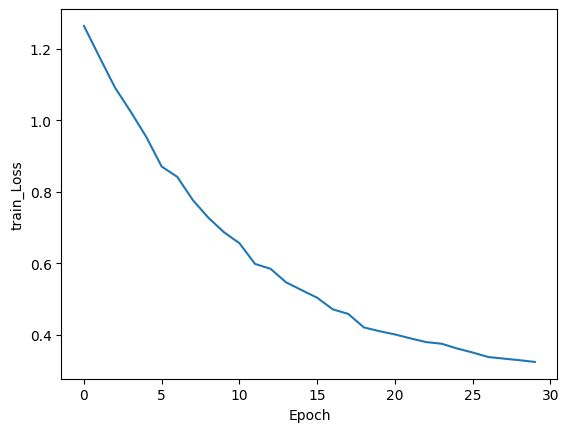

In [36]:
plt.xlabel('Epoch')
plt.ylabel('train_Loss')
plt.plot(epoch_list, train_loss_list)

epoch과 valid loss간의 관계 그래프이다.<br>
그래프를 보면 valid loss가 지속해서 증가하는 것을 확인할 수 있다.<br>
이건 왜 계속 증가하는지 확인이 필요할 거 같습니다.

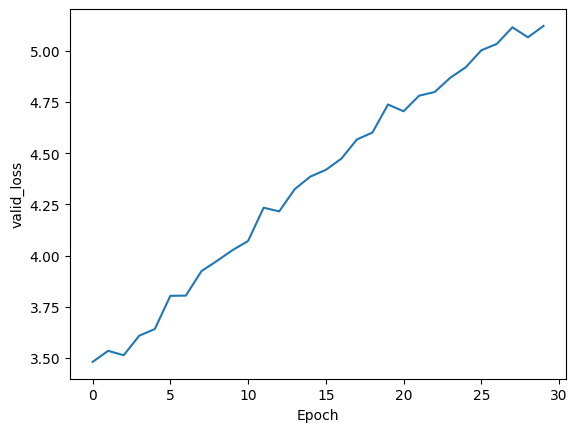

In [37]:
plt.xlabel('Epoch')
plt.ylabel('valid_loss')
plt.plot(epoch_list, valid_loss_list)

In [38]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.439 | Test PPL:  31.170 |
